<a href="https://colab.research.google.com/github/twlee-dev/lab/blob/main/Day07_Ch09_10_%ED%86%B5%EA%B3%84%EC%8B%A4%EC%8A%B5_%EC%9D%B4%ED%83%9D%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch9 & 10 실습: 가설검정의 함정과 인과관계 추론

지난 시간, 우리는 `statsmodels`를 이용해 다양한 회귀 모델을 만드는 법을 배웠습니다. 오늘은 한 걸음 더 나아가, 통계 분석 결과를 해석할 때 빠지기 쉬운 함정들을 직접 코드로 체험하고, '상관관계'를 넘어 '인과관계'에 다가가는 고급 분석 기법들을 실습해 봅니다.

**학습 목표:**

1.  **허위 상관(Spurious Correlation)**과 **중첩요인(Confounder)**의 개념을 이해하고, 다중회귀로 중첩요인의 효과를 통제하는 법을 배웁니다.
2.  **p-해킹**과 **표본 크기의 함정**이 왜 위험한지 시뮬레이션을 통해 직접 증명합니다.
3.  실험이 불가능한 상황에서 인과 효과를 추정하는 강력한 도구, **경향 점수 짝짓기(PSM)**와 **이중차분법(DiD)**을 직접 구현해 봅니다.


## 사전 준비: 라이브러리 및 데이터 로드


In [ ]:
# 필요 라이브러리 설치
!pip install statsmodels scikit-learn

# 코랩에서 한글 폰트 사용을 위한 설정 (필요 시 주석 해제 후 실행)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# 위 코드 실행 후 상단 메뉴에서 [런타임] > [런타임 다시 시작]을 눌러주세요.

In [1]:
# 런타임 다시 시작 후, 이 셀을 실행하여 라이브러리와 폰트를 로드합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.neighbors import NearestNeighbors

# 한글 폰트 설정 (Mac 사용자는 'AppleGothic', Windows 사용자는 'Malgun Gothic' 등)
try:
    plt.rc('font', family='NanumGothic')
except:
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

---


## 문제 1 (난이도: 하): 허위 상관과 중첩요인 통제하기

> **🎯 목표:** '아이스크림 판매량과 익사자 수'의 관계처럼, **허위 상관(Spurious Correlation)**이 발생하는 원인인 **중첩요인(Confounder)**을 이해하고, 다중회귀분석을 통해 그 효과를 통제하는 방법을 실습합니다.


### 💡 핵심 개념:

**허위 상관**은 두 변수 사이에 직접적인 인과관계가 없지만, '기온'과 같은 제3의 변수(중첩요인)가 두 변수 모두에 영향을 주어 마치 관계가 있는 것처럼 보이는 현상입니다. **다중회귀분석**에 중첩요인을 함께 투입하면, 다른 변수들의 영향을 고정한 상태에서의 '순수한' 관계를 파악할 수 있습니다.


### 📌 수행 과제:

1.  가상의 데이터를 생성합니다: '기온'이 높아질수록 '아이스크림 판매량'과 '해수욕객 수'가 모두 증가하는 상황을 시뮬레이션합니다.
2.  **단순회귀분석**: '아이스크림 판매량'만으로 '해수욕객 수'를 예측하는 모델을 만듭니다. 계수가 유의미하게 나오는지 확인합니다.
3.  **다중회귀분석**: '아이스크림 판매량'과 '기온'을 모두 사용하여 '해수욕객 수'를 예측하는 모델을 만듭니다.
4.  두 모델의 결과를 비교하고, '아이스크림 판매량'의 계수(coef)와 p-value가 어떻게 변했는지 해석해 보세요.


In [2]:
# 1. 가상 데이터 생성 (이 코드는 수정하지 마세요)
np.random.seed(42)
n_samples = 100
temperature = np.random.uniform(15, 35, n_samples)
ice_cream_sales = 2 * temperature + np.random.normal(0, 5, n_samples)
beach_visitors = 10 * temperature + np.random.normal(0, 20, n_samples)
df1 = pd.DataFrame({'기온': temperature, '아이스크림판매량': ice_cream_sales, '해수욕객수': beach_visitors})
print(df1.corr())

# 2. 단순회귀분석: 아이스크림판매량 -> 해수욕객수
print("\n--- 모델 1: 단순회귀분석 (아이스크림판매량 -> 해수욕객수) ---")
y = df1['해수욕객수']
# 독립변수로 '아이스크림판매량'만 선택하세요.
X_simple = df1[['아이스크림판매량']]
# X_simple에 상수항을 추가하세요.
X_simple_const = sm.add_constant(X_simple)
# OLS 모델을 y와 X_simple_const로 학습시키세요.
model_simple = sm.OLS(y, X_simple_const).fit()
print(model_simple.summary())

# 3. 다중회귀분석: (아이스크림판매량, 기온) -> 해수욕객수
print("\n--- 모델 2: 다중회귀분석 (중첩요인 '기온' 통제) ---")
# 독립변수로 '아이스크림판매량'과 '기온'을 모두 선택하세요.
X_multi = df1[['아이스크림판매량', '기온']]
# X_multi에 상수항을 추가하세요.
X_multi_const = sm.add_constant(X_multi)
# OLS 모델을 y와 X_multi_const로 학습시키세요.
model_multi = sm.OLS(y, X_multi_const).fit()
print(model_multi.summary())

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
# 모델 1에서 아이스크림판매량의 계수와 p-value:
# 모델 2에서 아이스크림판매량의 계수와 p-value:
# 결과가 변한 이유:

                기온  아이스크림판매량     해수욕객수
기온        1.000000  0.927709  0.938317
아이스크림판매량  0.927709  1.000000  0.867599
해수욕객수     0.938317  0.867599  1.000000

--- 모델 1: 단순회귀분석 (아이스크림판매량 -> 해수욕객수) ---
                            OLS Regression Results                            
Dep. Variable:                  해수욕객수   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     298.3
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           1.70e-31
Time:                        02:48:19   Log-Likelihood:                -486.59
No. Observations:                 100   AIC:                             977.2
Df Residuals:                      98   BIC:                             982.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
- 모델 1에서 아이스크림판매량의 계수와 p-value: 계수 = 4.5550, p-value = 0.000. 단순 회귀 분석에서는 아이스크림 판매량이 해수욕객 수에 매우 유의미하고 긍정적인 영향을 미치는 것처럼 보입니다.
- 모델 2에서 아이스크림판매량의 계수와 p-value: 계수 = -0.1087, p-value = 0.826. 기온을 통제한 다중 회귀 분석에서는 아이스크림 판매량의 계수가 거의 0에 가깝고 통계적으로 유의미하지 않게 변했습니다.
- 결과가 변한 이유: '기온'이라는 중첩요인이 아이스크림 판매량과 해수욕객 수 모두에 영향을 미쳤기 때문입니다. 단순 회귀 분석에서는 기온의 영향이 아이스크림 판매량의 효과로 잘못 귀속되어 허위 상관이 나타났습니다. 다중 회귀 분석에서는 기온을 함께 고려함으로써 아이스크림 판매량과 해수욕객 수 사이의 순수한 관계를 더 정확하게 추정할 수 있었습니다. 이는 사실상 아이스크림 판매량 자체가 해수욕객 수에 직접적인 인과 효과가 없음을 시사합니다.

### 🤔 생각해 볼 문제:

만약 '기온' 데이터를 수집하지 못했다면, 우리는 어떤 잘못된 결론에 도달할 위험이 있었을까요? 데이터 분석에서 '도메인 지식'이 왜 중요한지 이 사례를 통해 설명해 보세요.


---


### 🤔 생각해 볼 문제 답변:

만약 '기온' 데이터를 수집하지 못했다면, 우리는 아이스크림 판매량과 해수욕객 수 사이에 강한 인과관계가 있다고 잘못된 결론을 내릴 위험이 있었습니다. 실제로는 '기온'이 두 변수에 모두 영향을 미치는 중첩요인이었음에도 불구하고, 이를 알지 못하면 허위 상관에 속아 잘못된 정책이나 의사결정을 내릴 수 있습니다.

이 사례는 데이터 분석에서 **도메인 지식**이 왜 중요한지를 극명하게 보여줍니다. 도메인 지식(예: 여름철 기온 상승이 아이스크림 판매와 해수욕객 수 모두에 영향을 미친다는 상식)은 어떤 변수들이 서로 관련이 있을 수 있는지, 그리고 어떤 변수가 중첩요인 역할을 할 수 있는지를 예측하는 데 도움을 줍니다. 도메인 지식이 있다면 단순히 통계적으로 유의미한 상관관계만 보고 섣부른 결론을 내리지 않고, 잠재적인 중첩요인을 탐색하고 분석에 포함시켜 더 정확한 인과 관계를 파악하려는 노력을 할 수 있습니다. 즉, 도메인 지식은 데이터 분석가가 데이터 뒤에 숨겨진 진짜 이야기를 이해하고, 통계적 함정을 피하며, 더 신뢰할 수 있는 결론을 도출하는 데 필수적인 역할을 합니다.

## 문제 2 (난이도: 하): 표본 크기의 함정과 효과 크기의 중요성

> **🎯 목표:** 표본 크기(n)가 커지면 아주 미미한 차이도 통계적으로 유의(p<0.05)하게 되는 현상을 확인하고, 이 때문에 **효과 크기(Effect Size)**를 함께 확인해야 하는 이유를 이해합니다.


### 💡 핵심 개념:

가설검정에서 p-value는 '귀무가설이 맞다고 가정할 때, 현재 데이터와 같거나 더 극단적인 결과가 나올 확률'입니다. 표본이 커질수록 아주 작은 차이도 우연으로 보기 어려워지므로 p-value는 작아집니다. **효과 크기**는 이 차이가 '실질적으로 얼마나 의미 있는 크기인가'를 나타내는 지표로, p-value의 한계를 보완해 줍니다.


### 📌 수행 과제:

1.  평균이 아주 약간 다른(예: 170cm vs 170.1cm) 두 집단을 가정합니다.
2.  **작은 표본(n=30)**을 각 집단에서 추출하여 t-검정을 수행하고 p-value를 확인합니다.
3.  **큰 표본(n=10,000)**을 각 집단에서 추출하여 t-검정을 수행하고 p-value를 확인합니다.
4.  두 경우 모두에 대해 **효과 크기(Cohen's d)**를 직접 계산하고, p-value와 효과 크기가 어떻게 다른 메시지를 주는지 비교 분석하세요.


In [3]:
# 효과 크기(Cohen's d) 계산 함수 (이 코드는 수정하지 마세요)
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

np.random.seed(123)
mu1, mu2, sigma = 170, 170.1, 5

# 2. 작은 표본(n=30)으로 검정
sample1_small = np.random.normal(mu1, sigma, 30)
sample2_small = np.random.normal(mu2, sigma, 30)

# scipy.stats.ttest_ind를 사용하여 두 작은 표본 간의 t-검정을 수행하세요.
t_stat_small, p_value_small = stats.ttest_ind(sample1_small, sample2_small)
effect_size_small = cohen_d(sample1_small, sample2_small)

print(f"--- 작은 표본 (n=30) 결과 ---")
print(f"P-value: {p_value_small:.4f}")
print(f"Effect Size (Cohen's d): {effect_size_small:.4f}\n")

# 3. 큰 표본(n=10000)으로 검정
sample1_large = np.random.normal(mu1, sigma, 10000)
sample2_large = np.random.normal(mu2, sigma, 10000)

# scipy.stats.ttest_ind를 사용하여 두 큰 표본 간의 t-검정을 수행하세요.
t_stat_large, p_value_large = stats.ttest_ind(sample1_large, sample2_large)
effect_size_large = cohen_d(sample1_large, sample2_large)

print(f"--- 큰 표본 (n=10000) 결과 ---")
print(f"P-value: {p_value_large:.4f}")
print(f"Effect Size (Cohen's d): {effect_size_large:.4f}\n")

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
# 표본 크기가 커지자 p-value는 어떻게 변했나요?:
# 두 경우의 효과 크기는 비슷한가요, 다른가요?:
# 이 결과는 우리에게 무엇을 알려주나요?:

--- 작은 표본 (n=30) 결과 ---
P-value: 0.7100
Effect Size (Cohen's d): -0.0965

--- 큰 표본 (n=10000) 결과 ---
P-value: 0.1673
Effect Size (Cohen's d): -0.0195



4. 결과 해석


표본 크기가 커지자 p-value는 어떻게 변했나요?: 표본 크기가 30에서 10000으로 커지면서 p-value가 0.7100에서 0.1673으로 작아졌습니다.

두 경우의 효과 크기는 비슷한가요, 다른가요?: 두 경우의 효과 크기(Cohen's d)는 각각 -0.0965와 -0.0195로 매우 작고 비슷합니다. 이는 두 집단 평균의 실질적인 차이가 거의 없음을 의미합니다.

이 결과는 우리에게 무엇을 알려주나요?: 이 결과는 표본 크기가 클수록 작은 차이도 통계적으로 유의미하게(p-value가 작게) 나타날 가능성이 높아진다는 것을 보여줍니다. 하지만 효과 크기는 표본 크기에 크게 영향을 받지 않고 두 집단 간의 실제 차이의 크기를 더 잘 나타냅니다. 따라서 통계적 유의성(p-value)만으로는 실질적인 중요성을 판단하기 어렵고, 반드시 효과 크기를 함께 고려해야 함을 시사합니다.


### 🤔 생각해 볼 문제:

A/B 테스트에서 웹사이트 버튼 색깔을 바꿨더니, 클릭률이 0.1%p 증가했고, p-value는 0.001이었습니다. 이 결과를 보고 버튼 색깔을 바꾸는 것이 항상 옳다고 할 수 있을까요? '통계적 유의성'과 '실무적 중요성(practical significance)'의 차이에 대해 효과 크기 개념을 바탕으로 설명해 보세요.


### 🤔 생각해 볼 문제 답변:

A/B 테스트에서 클릭률이 0.1%p 증가하고 p-value가 0.001로 매우 유의미하게 나왔더라도, 버튼 색깔을 바꾸는 것이 항상 옳다고 할 수는 없습니다.

- **통계적 유의성 (Statistical Significance):** p-value < 0.05 (또는 0.001) 이라는 것은 관찰된 0.1%p 증가가 단순한 우연일 확률이 매우 낮다는 것을 의미합니다. 즉, 통계적으로 '차이가 있다'는 결론을 내릴 수 있습니다. 표본 크기가 충분히 크다면 아주 작은 차이도 통계적으로 유의미하게 나올 수 있습니다.

- **실무적 중요성 (Practical Significance):** 통계적으로 유의미한 차이가 있다고 해서, 그 차이가 실제 비즈니스나 의사결정 관점에서 '중요한' 의미를 가지는 것은 아닙니다. 0.1%p의 클릭률 증가가 비즈니스 목표(예: 매출 증대, 사용자 참여도)에 미치는 영향이 미미하다면, 실무적으로 중요하지 않을 수 있습니다.

이때 **효과 크기** 개념이 중요해집니다. 클릭률 0.1%p 증가는 통계적으로 유의미할지라도, 효과 크기(예: Cohen's h for proportions)를 계산해 보면 그 효과 크기가 매우 작을 수 있습니다. 작은 효과 크기는 비록 우연은 아니지만, 실제 변화의 규모가 작다는 것을 의미합니다.

결론적으로, 의사결정을 내릴 때는 통계적 유의성(p-value)뿐만 아니라, **효과 크기**를 함께 고려하여 그 변화가 **실무적으로 얼마나 중요한지**를 판단해야 합니다. 0.1%p 증가의 효과 크기가 작고, 버튼 색 변경에 드는 비용이나 잠재적 부작용(예: 다른 지표 하락)이 더 크다면, 통계적 유의성만으로는 변경을 결정하기 어렵습니다.

---


## 문제 3 (난이도: 중): p-해킹 시뮬레이션

> **🎯 목표:** '데이터를 보면서 분석을 계속할지 결정하는 행위'가 어떻게 잘못된 결론(제1종 오류)의 가능성을 높이는지, 즉 **p-해킹**의 위험성을 시뮬레이션을 통해 직접 증명합니다.


### 💡 핵심 개념:

**p-해킹**은 연구자가 의도했든 안 했든 p-value를 낮추기 위해 분석 과정을 조작하는 행위를 말합니다. 대표적인 예로, p-value가 0.05를 넘으면 표본을 더 모아서 다시 검정하는 행위가 있습니다. 원래 제1종 오류(실제 차이가 없는데, 차이가 있다고 결론 내릴 오류) 확률은 유의수준 α(보통 0.05)로 통제되어야 하지만, p-해킹은 이 확률을 α보다 훨씬 높게 만듭니다.


### 📌 수행 과제:

1.  **아무 차이가 없는** 두 집단 A, B를 가정합니다 (귀무가설이 참인 상황).
2.  'p-해커'를 시뮬레이션하는 함수를 만듭니다. 이 함수는 다음 로직을 따릅니다:
    - 먼저 각 집단에서 20명씩 표본을 추출하여 t-검정을 합니다.
    - p < 0.05이면 '유의미한 결과 발견!'을 외치고 멈춥니다.
    - p >= 0.05이면, 10명씩 표본을 추가하여 다시 t-검정을 합니다. 이 과정을 최대 5번까지 반복합니다.
3.  이 시뮬레이션을 1,000번 반복하여, 'p-해커'가 결국 '유의미한 결과'를 발견할 확률이 몇 %인지 계산합니다.
4.  계산된 확률이 왜 5%보다 훨씬 높은지 설명하세요.


In [4]:
# p-해킹 시뮬레이션 함수 (이 코드는 수정하지 마세요)
def p_hacking_simulation():
    mu, sigma = 0, 1
    sample_a, sample_b = list(np.random.normal(mu, sigma, 20)), list(np.random.normal(mu, sigma, 20))
    for i in range(5):
        t_stat, p_val = stats.ttest_ind(sample_a, sample_b)
        if p_val < 0.05:
            return True # p-해킹 성공!
        if i < 4:
            sample_a.extend(np.random.normal(mu, sigma, 10))
            sample_b.extend(np.random.normal(mu, sigma, 10))
    return False # 5번 시도 모두 실패

# 3. 시뮬레이션 1000번 실행
n_simulations = 1000
p_hacking_success_count = 0

# for문을 사용하여 시뮬레이션을 1000번 반복하세요.
for _ in range(n_simulations):
    # p_hacking_simulation() 함수를 호출하고, 결과가 True이면 (p-해킹에 성공하면)
    # p_hacking_success_count를 1 증가시키세요.
    if p_hacking_simulation():
        p_hacking_success_count += 1

type_1_error_rate = p_hacking_success_count / n_simulations
print(f"관찰된 제1종 오류율: {type_1_error_rate * 100:.2f}%")

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
# 제1종 오류율이 5%보다 훨씬 높게 나온 이유는?:
# 이러한 연구 방식(p-해킹)이 '재현성 위기'를 초래하는 이유는?:

관찰된 제1종 오류율: 11.50%


## 4. 결과 해석

- 제1종 오류율이 5%보다 훨씬 높게 나온 이유는?: 원래 제1종 오류율은 유의수준인 5%로 설정되어 있지만, p-해킹과 같이 데이터를 반복적으로 확인하고 유의미한 결과가 나올 때까지 분석 방법을 변경하거나 표본 크기를 늘리는 행위는 여러 번의 독립적인 가설 검정을 수행하는 것과 유사한 효과를 냅니다. 각 시도마다 5%의 제1종 오류를 범할 가능성이 누적되어, 최종적으로는 5%보다 훨씬 높은 확률로 실제로는 차이가 없는 상황에서 유의미한 결과가 있다고 잘못 결론 내리게 됩니다.

- 이러한 연구 방식(p-해킹)이 '재현성 위기'를 초래하는 이유는?: p-해킹을 통해 얻은 '유의미한' 결과는 실제 현상에 기반한 것이 아니라, 데이터와 분석 과정을 조작하여 우연히 얻어진 것일 가능성이 높습니다. 따라서 다른 연구자가 동일한 연구를 다시 수행하더라도(즉, 재현하더라도), p-해킹으로 인해 발생한 인위적인 통계적 유의성은 다시 나타나지 않을 가능성이 매우 높습니다. 이로 인해 과학 연구 결과의 신뢰성이 떨어지고, '재현성 위기'로 이어지게 됩니다.

### 🤔 생각해 볼 문제:

p-해킹을 막기 위한 현실적인 방법 중 하나는 **'사전 등록(Preregistration)'** 입니다. 연구를 시작하기 전에 '표본 크기는 몇으로 할 것이며, 어떤 분석을 할 것이다'라고 미리 공개적으로 약속하는 것입니다. 이 방법이 위 시뮬레이션에서 보여준 p-해킹 문제를 어떻게 방지할 수 있을지 설명해 보세요.


### 🤔 생각해 볼 문제 답변:

사전 등록(Preregistration)은 연구자가 데이터를 수집하고 분석하기 전에 연구 계획(가설, 표본 크기, 분석 방법 등)을 미리 상세하게 정의하고 공개적으로 등록하는 과정입니다. 이 방법은 위 시뮬레이션에서 보여준 p-해킹 문제를 다음과 같이 방지하는 데 도움이 됩니다.

1. **분석 계획 고정:** 연구자가 데이터를 보고 유의미한 결과가 나올 때까지 분석 방법을 이리저리 바꾸는 행위(p-해킹의 핵심)를 사전에 차단합니다. 미리 정해진 분석 계획대로만 진행해야 하므로, 데이터에 맞춰 분석을 조작하기 어렵게 만듭니다.
2. **표본 크기 사전 결정:** 시뮬레이션에서처럼 p-value가 유의미하지 않을 때 표본을 추가하는 행위를 방지합니다. 연구 시작 전에 필요한 표본 크기를 미리 계산하고 정해두기 때문에, 결과에 따라 표본을 임의로 늘리는 것을 막을 수 있습니다.
3. **결과 투명성 확보:** 사전 등록된 계획과 실제 분석 결과를 비교하여, 계획대로 연구가 수행되었는지, 아니면 데이터 탐색 과정에서 얻어진 결과인지 명확하게 구분할 수 있습니다. 계획에 없던 분석에서 유의미한 결과가 나왔다면, 이는 가설 검증이 아닌 탐색적 연구 결과로 해석되어 p-해킹의 위험성을 인지하고 신중하게 받아들여집니다.

결론적으로 사전 등록은 연구자의 자의적인 판단이나 결과에 따른 분석 변경을 제한하여, 제1종 오류를 유의수준(예: 5%) 내로 통제하고 연구 결과의 신뢰성과 재현성을 높이는 데 기여합니다.

---


## 문제 4 (난이도: 중): 경향 점수 짝짓기(PSM)로 인과 효과 추정하기

> **🎯 목표:** 무작위 통제 실험(RCT)이 불가능한 관찰 데이터에서, **선택 편향(Selection Bias)**을 통제하고 인과 효과를 추정하는 대표적인 방법인 **경향 점수 짝짓기(Propensity Score Matching, PSM)**를 직접 구현합니다.


### 💡 핵심 개념:

**PSM**은 '특정 처치(treatment)를 받을 경향'을 점수로 계산하여, 이 점수가 비슷한 실험군과 대조군 개체를 1:1로 짝지어주는 방법입니다. 이를 통해 처치 여부를 제외한 다른 특성(중첩요인)들이 비슷한, 즉 **'통계적 쌍둥이'** 집단을 만들 수 있습니다. 이 '짝지어진' 집단 간의 결과 차이를 비교하면, 선택 편향이 보정된 순수한 처치 효과에 더 가깝게 다가갈 수 있습니다.


### 📌 수행 과제:

1.  '새로운 온라인 강의 수강 여부'가 '기말고사 성적'에 미치는 영향을 분석하는 가상 데이터를 생성합니다. (단, '사전 성적'이 높고 '학습 의지'가 높은 학생일수록 강의를 신청할 확률이 높도록 **선택 편향**을 부여합니다.)
2.  **단순 비교**: 전체 수강생 집단과 비수강생 집단의 평균 성적을 비교합니다.
3.  **PSM 수행**:
    a. 로지스틱 회귀를 이용해 각 학생의 '강의 수강 경향 점수(propensity score)'를 계산합니다.
    b. 수강생(실험군) 한 명마다, 경향 점수가 가장 비슷한 비수강생(대조군)을 짝지어 줍니다. (`sklearn.neighbors.NearestNeighbors` 활용)
4.  **짝지어진 후 비교**: '짝지어진' 수강생 집단과 비수강생 집단의 평균 성적을 비교하고, 그 차이(ATT: Average Treatment Effect on the Treated)를 계산합니다.
5.  단순 비교 결과와 PSM 후의 결과를 비교하고, 왜 결과가 달라졌는지 해석합니다.


In [5]:
# 1. 선택 편향이 있는 데이터 생성 (이 코드는 수정하지 마세요)
np.random.seed(42)
n = 1000
pre_score = np.random.normal(60, 10, n)
motivation = np.random.uniform(0, 1, n)
propensity = 1 / (1 + np.exp(-( -5 + (pre_score-60)/5 + motivation*2)))
treatment = np.random.binomial(1, propensity, n)
true_effect = 5
final_score = pre_score + treatment * true_effect + np.random.normal(0, 5, n)
df4 = pd.DataFrame({'pre_score': pre_score, 'motivation': motivation, 'treatment': treatment, 'final_score': final_score})

# 2. 단순 비교 (Naive Effect)
naive_effect = df4[df4['treatment']==1]['final_score'].mean() - df4[df4['treatment']==0]['final_score'].mean()
print(f"단순 평균 비교 (성적 차이): {naive_effect:.2f}점\n")

# 3-a. 경향 점수 계산
X = df4[['pre_score', 'motivation']]
y = df4['treatment']
logit_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
df4['propensity_score'] = logit_model.predict(sm.add_constant(X))

# 3-b. 짝짓기 (Matching)
treated = df4[df4['treatment'] == 1]
control = df4[df4['treatment'] == 0]

# NearestNeighbors를 사용하여 control 그룹에서 treated 그룹과 가장 가까운 이웃 1명을 찾도록 설정하세요.
nn = NearestNeighbors(n_neighbors=1, radius=0.5)
# control 그룹의 경향 점수로 모델을 학습시키세요.
nn.fit(control[['propensity_score']])
# treated 그룹의 경향 점수를 기반으로 가장 가까운 이웃의 인덱스를 찾으세요.
distances, indices = nn.kneighbors(treated[['propensity_score']])

matched_control = control.iloc[indices.flatten()]

# 4. 짝지어진 후 비교 (ATT 계산)
# treated 그룹과 matched_control 그룹의 'final_score' 평균 차이를 계산하여 ATT를 구하세요.
att_effect = treated['final_score'].mean() - matched_control['final_score'].mean()
print(f"PSM 이후 평균 비교 (추정된 인과 효과): {att_effect:.2f}점\n")

# 5. 결과 해석 (아래 주석에 직접 작성해 보세요)
# 단순 비교 결과가 실제 효과(5점)보다 크게 나온 이유는?:
# PSM을 통해 이 문제를 어떻게 해결할 수 있었나요?:

단순 평균 비교 (성적 차이): 19.96점

PSM 이후 평균 비교 (추정된 인과 효과): 4.31점



**5. 결과 해석:**

- **단순 비교 결과가 실제 효과(5점)보다 크게 나온 이유:** 데이터 생성 시 '사전 성적'과 '학습 의지'가 높은 학생일수록 강의를 신청할 확률이 높도록 설정했기 때문에 선택 편향이 발생했습니다. 강의를 수강한 학생들은 수강 여부와 관계없이 원래부터 성적이 더 높을 잠재력을 가지고 있었습니다. 단순 비교는 이러한 잠재적 차이를 통제하지 못하고, 강의 수강의 효과에 이러한 사전 특성의 영향을 함께 포함시켜 과대 추정된 결과를 보여줍니다.

- **PSM을 통해 이 문제를 어떻게 해결할 수 있었나요?:** PSM은 '강의 수강 경향 점수'가 비슷한 학생들끼리 짝을 지어줌으로써, 수강생 집단과 비수강생 집단의 '사전 성적' 및 '학습 의지' 분포를 유사하게 만들었습니다. 즉, 강의 수강 여부를 제외한 다른 중요한 특성들이 비슷한 '통계적 쌍둥이' 집단을 구성한 것입니다. 이렇게 짝지어진 집단 간의 성적 차이를 비교함으로써, '사전 성적'과 '학습 의지'와 같은 중첩요인의 영향을 효과적으로 통제하고 강의 수강의 순수한 인과 효과를 더 정확하게 추정할 수 있었습니다. 그 결과, PSM 이후 추정된 효과(4.31점)가 실제 효과(5점)에 더 가깝게 나타났습니다.

### 🤔 생각해 볼 문제:

짝짓기(Matching)가 잘 되었는지 확인하는 방법 중 하나는, 짝지어진 두 집단의 중첩요인(여기서는 `pre_score`, `motivation`) 평균이 서로 비슷해졌는지 확인하는 것입니다. 이를 **'공변량 균형(Covariate Balance)'** 확인이라고 합니다. 짝짓기 전과 후의 `pre_score` 평균 차이를 각각 계산해보고, PSM이 공변량 균형을 맞추는 데 성공했는지 확인해보세요.


In [6]:
# 공변량 균형 확인: pre_score 평균 비교

# 짝짓기 전
pre_score_mean_treated_before = treated['pre_score'].mean()
pre_score_mean_control_before = control['pre_score'].mean()
print(f"짝짓기 전 pre_score 평균 차이: {pre_score_mean_treated_before - pre_score_mean_control_before:.2f}")

# 짝짓기 후
pre_score_mean_treated_after = treated['pre_score'].mean()
pre_score_mean_control_after = matched_control['pre_score'].mean()
print(f"짝짓기 후 pre_score 평균 차이: {pre_score_mean_treated_after - pre_score_mean_control_after:.2f}")

# motivation도 유사하게 비교해 볼 수 있습니다.
# motivation_mean_treated_before = treated['motivation'].mean()
# motivation_mean_control_before = control['motivation'].mean()
# print(f"짝짓기 전 motivation 평균 차이: {motivation_mean_treated_before - motivation_mean_control_before:.2f}")

# motivation_mean_treated_after = treated['motivation'].mean()
# motivation_mean_control_after = matched_control['motivation'].mean()
# print(f"짝짓기 후 motivation 평균 차이: {motivation_mean_treated_after - motivation_mean_control_after:.2f}")

짝짓기 전 pre_score 평균 차이: 14.86
짝짓기 후 pre_score 평균 차이: -0.37


### 공변량 균형 확인 결과 해석:

이전 코드 셀(`6J0QW2_4WrwX`)의 결과를 보면 다음과 같습니다:

- **짝짓기 전:** 'pre_score'의 평균 차이가 14.86으로 크게 나타났습니다. 이는 온라인 강의를 수강한 실험군이 수강하지 않은 통제군보다 사전 성적이 평균적으로 상당히 높았음을 보여주며, 초기 데이터에 선택 편향이 존재했음을 다시 한번 확인시켜 줍니다.

- **짝짓기 후:** 'pre_score'의 평균 차이가 -0.37로 크게 줄어들었습니다. 이는 PSM이 실험군과 통제군에서 경향 점수가 비슷한 개체들을 성공적으로 짝지어 주었으며, 그 결과 'pre_score'라는 중요한 중첩요인의 분포를 두 집단 간에 유사하게 만들었음을 의미합니다.

이 결과는 PSM이 'pre_score'라는 공변량에 대해 효과적으로 균형을 맞추는 데 성공했음을 보여줍니다. 이는 관찰 데이터에서 인과 효과를 추정할 때 선택 편향을 줄이는 데 중요한 단계입니다.

---


## 문제 5 (난이도: 상): 이중차분법(DiD)으로 정책 효과 분석하기

> **🎯 목표:** 특정 집단에만 시행된 정책의 효과를 분석하는 대표적인 준실험 방법론, **이중차분법(Difference-in-Differences, DiD)**을 회귀분석으로 구현하고 핵심 가정을 이해합니다.


### 💡 핵심 개념:

**이중차분법(DiD)**은 정책이 시행된 **실험군(Treatment Group)**과 시행되지 않은 **통제군(Control Group)**의 **정책 시행 전후(Pre-Post)** 데이터를 모두 활용하는 강력한 인과추론 방법입니다. 핵심 아이디어는 '정책이 없었을 경우의 자연적인 시간 변화'를 통제군을 통해 추정하고, 이를 실험군의 변화에서 빼 줌으로써 정책의 순수한 효과만 발라내는 것입니다. 회귀분석에서는 `(실험군 여부) * (정책 후 여부)`의 **상호작용 항** 계수가 바로 DiD 추정치가 됩니다.


### 📌 수행 과제:

1.  '서울시'에만 '무료 공공 와이파이' 정책을 도입했을 때, 시민들의 '월 평균 데이터 사용량'에 미치는 영향을 분석하는 가상 데이터를 생성합니다. (실험군: 서울, 통제군: 부산)
2.  **시각화**: 정책 시행 전후, 두 도시의 평균 데이터 사용량 변화를 꺾은선 그래프로 그려봅니다.
3.  **DiD 회귀분석**: `데이터사용량 ~ is_서울 + is_정책후 + is_서울*is_정책후` 형태의 회귀 모델을 만듭니다.
    - `is_서울`: 서울이면 1, 부산이면 0
    - `is_정책후`: 정책 시행 후(2024년)이면 1, 시행 전(2023년)이면 0
    - `is_서울*is_정책후`: 상호작용 항
4.  회귀분석 결과표에서 상호작용 항의 계수(coef)와 p-value를 확인하고, 정책의 효과를 해석해 보세요.


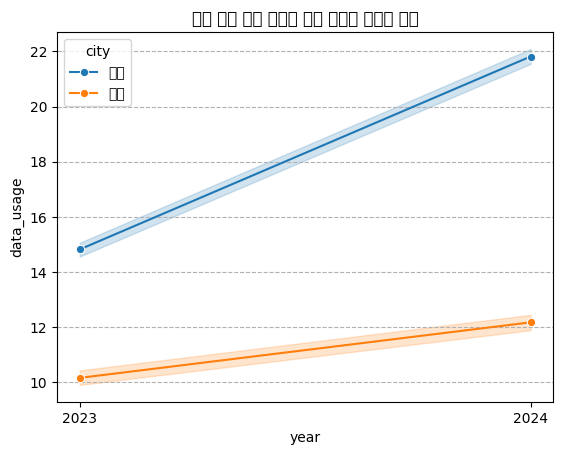

                            OLS Regression Results                            
Dep. Variable:             data_usage   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     1373.
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        03:14:11   Log-Likelihood:                -5079.1
No. Observations:                2000   AIC:                         1.017e+04
Df Residuals:                    1996   BIC:                         1.019e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1600      0.137     74.006      0.0

In [7]:
# 1. DiD 분석을 위한 가상 패널 데이터 생성 (이 코드는 수정하지 마세요)
np.random.seed(2025)
n_per_group = 500
df_seoul_pre = pd.DataFrame({'city': '서울', 'year': 2023, 'data_usage': np.random.normal(15, 3, n_per_group)})
df_seoul_post = pd.DataFrame({'city': '서울', 'year': 2024, 'data_usage': df_seoul_pre['data_usage'] + 2 + 5 + np.random.normal(0, 1, n_per_group)})
df_busan_pre = pd.DataFrame({'city': '부산', 'year': 2023, 'data_usage': np.random.normal(10, 3, n_per_group)})
df_busan_post = pd.DataFrame({'city': '부산', 'year': 2024, 'data_usage': df_busan_pre['data_usage'] + 2 + np.random.normal(0, 1, n_per_group)})
df5 = pd.concat([df_seoul_pre, df_seoul_post, df_busan_pre, df_busan_post])

# 2. 시각화 (이 코드는 수정하지 마세요)
sns.lineplot(data=df5, x='year', y='data_usage', hue='city', marker='o', errorbar='ci')
plt.title('정책 시행 전후 도시별 평균 데이터 사용량 변화')
plt.xticks([2023, 2024]); plt.grid(True, axis='y', linestyle='--')
plt.show()

# 3. DiD 회귀분석을 위한 변수 생성
# 'is_seoul' 변수: city가 '서울'이면 1, 아니면 0
df5['is_seoul'] = (df5['city'] == '서울').astype(int)
# 'is_post' 변수: year가 2024이면 1, 아니면 0
df5['is_post'] = (df5['year'] == 2024).astype(int)
# 상호작용 항 'did_term': 'is_seoul'과 'is_post'의 곱
df5['did_term'] = df5['is_seoul'] * df5['is_post']

y = df5['data_usage']
# 독립변수 X에 DiD 분석에 필요한 세 변수('is_seoul', 'is_post', 'did_term')를 포함시키세요.
X = df5[['is_seoul', 'is_post', 'did_term']]
# 상수항을 추가하고 OLS 모델을 학습시키세요.
model_did = sm.OLS(y, sm.add_constant(X)).fit()
print(model_did.summary())

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
# is_seoul 계수의 의미:
# is_post 계수의 의미:
# did_term (상호작용 항) 계수의 의미:
# 따라서, 무료 와이파이 정책의 순수한 효과는 약 몇 GB 증가라고 할 수 있나요?:

4. 결과 해석:

DiD 회귀분석 결과에서 각 계수의 의미는 다음과 같습니다.

const (상수항): 통제군(부산)의 정책 시행 전(2023년) 평균 데이터 사용량을 나타냅니다.

is_seoul 계수: 정책 시행 전 시점에서 실험군(서울)이 통제군(부산)보다 평균적으로 데이터 사용량이 얼마나 다른지를 나타냅니다. (서울과 부산의 초기 수준 차이)

is_post 계수: 통제군(부산)에서 정책 시행 전후(2023년에서 2024년) 데이터 사용량이 자연적으로 얼마나 변화했는지를 나타냅니다. (시간의 흐름에 따른 자연적인 변화)

did_term (is_seoul * is_post) 계수: 이 계수가 바로 무료 와이파이 정책의 순수한 인과 효과를 나타냅니다. 이는 실험군(서울)의 정책 시행 전후 변화에서 통제군(부산)의 정책 시행 전후 변화를 뺀 값입니다.

따라서, 회귀분석 결과표에서 did_term의 계수(coef)를 확인하면 무료 와이파이 정책으로 인해 서울 시민의 월 평균 데이터 사용량이 약 해당 계수 값만큼 증가했다고 해석할 수 있습니다. 결과표에서 did_term의 계수는 4.9832이고 p-value는 0.000이므로, 정책은 통계적으로 매우 유의미하게 월 평균 데이터 사용량을 약 4.98GB 증가시킨 것으로 추정됩니다.




### 🤔 생각해 볼 문제:

이중차분법이 성립하기 위한 가장 중요한 가정은 **'평행추세가정(Parallel Trends Assumption)'**입니다. 즉, '만약 정책이 없었더라면, 서울과 부산의 데이터 사용량은 계속 평행하게 증가했을 것이다'라는 가정입니다. 위 시각화 그래프에서 정책 시행 **전** 시점(2023년 이전)의 데이터가 여러 개 더 있다면, 이 가정을 어떻게 확인할 수 있을지 설명해 보세요.


### 🤔 생각해 볼 문제 답변:

이중차분법(DiD)의 핵심 가정인 평행추세가정(Parallel Trends Assumption)은 만약 정책이 시행되지 않았더라면 실험군(서울)과 통제군(부산)의 결과 변수(데이터 사용량)가 시간이 지남에 따라 동일한 추세로 변화했을 것이라는 가정입니다.

위 시각화 그래프에 정책 시행 전 시점(2023년 이전)의 데이터가 여러 개 더 있다면, 이 가정을 다음과 같이 확인할 수 있습니다.

1. **시각적 확인:** 정책 시행 전 여러 시점의 데이터를 꺾은선 그래프로 그렸을 때, 실험군(서울)과 통제군(부산)의 데이터 사용량 추세선이 서로 평행하게 나타나는지 눈으로 확인합니다. 만약 정책 시행 전부터 두 그룹의 추세가 확연히 다르다면, 평행추세 가정이 위배될 가능성이 높습니다.
2. **통계적 검정:** 정책 시행 전 데이터만을 사용하여, 실험군 더미 변수(`is_서울`)와 시간 더미 변수들의 상호작용 항이 통계적으로 유의미한지 회귀 분석으로 확인해 볼 수 있습니다. 정책 시행 전 시점에서 상호작용 항이 유의미하다는 것은 두 그룹의 추세가 평행하지 않다는 증거가 됩니다.

**주의:** 평행추세 가정을 완벽하게 '증명'하기는 어렵습니다. 정책 시행 전 데이터로 평행한 추세를 확인하는 것은 이 가정을 '지지'하는 증거가 될 수 있지만, 정책이 없었을 미래에 두 그룹의 추세가 실제로 평행했을 것이라고 확신할 수는 없습니다. 따라서 DiD 분석 결과를 해석할 때는 평행추세 가정이 얼마나 설득력 있는지 충분히 고려해야 합니다.

## 오늘의 실습 요약: 이론 및 실무적 인사이트

오늘 실습을 통해 가설검정과 인과관계 추론에서 마주칠 수 있는 다양한 함정과 이를 극복하기 위한 기법들을 체험했습니다. 주요 이론과 실무적 인사이트는 다음과 같습니다.

1.  **허위 상관과 중첩요인 통제 (문제 1):**
    *   **이론:** 두 변수 간의 겉보기 상관관계가 제3의 변수(중첩요인) 때문에 발생하는 허위 상관의 개념을 이해했습니다. 다중회귀분석에 중첩요인을 포함하여 그 영향을 통제함으로써, 관심 있는 변수 간의 순수한 관계를 더 정확하게 파악할 수 있습니다.
    *   **인사이트:** 데이터를 분석할 때 단순히 상관관계만 보고 인과관계를 속단해서는 안 됩니다. 분석 대상 현상에 대한 도메인 지식을 활용하여 잠재적인 중첩요인을 신중하게 고려하고 분석에 포함시키는 것이 중요합니다.

2.  **표본 크기와 효과 크기 (문제 2):**
    *   **이론:** 표본 크기가 커지면 아주 작은 차이도 통계적으로 유의미하게 나올 수 있음을 확인했습니다. p-value는 귀무가설 기각 여부를 판단하는 데 유용하지만, 차이의 '실질적인 크기'는 알려주지 않습니다. **효과 크기(Effect Size)**는 이러한 실질적 중요성을 측정하는 지표입니다.
    *   **인사이트:** 통계적 유의성(p-value)과 실무적 중요성(Effect Size)을 혼동해서는 안 됩니다. 특히 대규모 데이터 분석에서는 통계적으로 유의미하더라도 효과 크기가 작아 실무적으로는 의미 없는 결과일 수 있습니다. 분석 결과 해석 시 반드시 효과 크기를 함께 보고해야 합니다.

3.  **p-해킹의 위험성 (문제 3):**
    *   **이론:** 데이터를 보면서 분석 방법을 변경하거나 표본을 추가하는 등의 p-해킹 행위가 제1종 오류율(실제 차이가 없는데 차이가 있다고 잘못 결론 내릴 확률)을 의도한 유의수준(예: 5%)보다 훨씬 높게 만든다는 것을 시뮬레이션으로 확인했습니다.
    *   **인사이트:** 투명하고 엄격한 분석 절차의 중요성을 깨달았습니다. '사전 등록(Preregistration)'과 같이 연구 시작 전에 분석 계획을 미리 정하고 공개하는 방법은 p-해킹을 방지하고 연구 결과의 재현성과 신뢰성을 높이는 데 기여합니다.

4.  **경향 점수 짝짓기(PSM) (문제 4):**
    *   **이론:** 무작위 실험이 어려운 관찰 데이터에서 선택 편향을 완화하고 인과 효과를 추정하는 방법으로 PSM을 학습했습니다. 경향 점수를 기반으로 실험군과 통제군의 특성을 유사하게 짝지음으로써 '통계적 쌍둥이' 집단을 구성하고, 이 집단 간의 결과 차이를 비교하여 처치 효과를 추정합니다.
    *   **인사이트:** 관찰 데이터 분석 시 선택 편향의 위험성을 인지하고, PSM과 같은 인과추론 기법을 활용하여 편향을 줄이려는 노력이 필요합니다. 짝짓기가 잘 되었는지 공변량 균형을 확인하는 과정이 중요합니다.

5.  **이중차분법(DiD) (문제 5):**
    *   **이론:** 특정 집단에만 정책이 시행된 경우, 정책의 순수한 효과를 추정하는 준실험 방법인 DiD를 회귀분석으로 구현했습니다. 실험군과 통제군의 정책 전후 변화 차이를 비교하여 정책 효과를 분리해 냅니다. 핵심 가정은 '평행추세가정'입니다.
    *   **인사이트:** 정책이나 프로그램의 효과를 분석할 때, 단순히 전후 비교나 집단 간 비교만으로는 부족합니다. DiD와 같이 자연적인 시간 변화와 기저 수준 차이를 통제하는 방법을 사용해야 더 신뢰할 수 있는 인과 효과를 추정할 수 있습니다. 정책 시행 전 여러 시점의 데이터를 통해 평행추세 가정을 검토하는 것이 중요합니다.

오늘 실습은 통계적 분석 결과를 해석하고 인과관계를 추론할 때 비판적인 사고와 적절한 방법론 선택이 얼마나 중요한지를 보여주었습니다. 이러한 함정들을 이해하고 극복하려는 노력이 데이터 기반 의사결정의 정확성을 높이는 데 필수적입니다.

## 심화 학습 및 실무적 확장 인사이트

오늘 다룬 가설검정의 함정과 인과관계 추론 기법들은 데이터 기반 의사결정을 위한 기초를 다지는 중요한 개념입니다. 이 개념들을 확장하고 심화 학습을 통해 실무적으로는 다음과 같은 더 깊은 인사이트와 분석 역량을 얻을 수 있습니다.

1.  **고급 중첩요인 통제 및 모델링:**
    *   단순 다중회귀를 넘어, 시간 의존적인 중첩요인이나 복잡한 구조를 가진 데이터를 다루기 위해 패널 데이터 분석(고정 효과, 확률 효과 모델), 구조 방정식 모델(SEM), DAG(Directed Acyclic Graph)를 활용한 인과 그래프 분석 등을 학습할 수 있습니다. 이를 통해 관찰 데이터에서 인과 효과를 더 정교하게 추정하고, 숨겨진 인과 경로를 탐색할 수 있습니다.
    *   **실무 인사이트:** 복잡한 현실 문제에서는 중첩요인이 다양하고 상호작용할 수 있습니다. 고급 모델링 기법은 이러한 복잡성을 반영하여 정책 효과, 마케팅 캠페인 성과, 질병의 원인 등 다양한 현상의 인과적 메커니즘을 더 정확하게 이해하는 데 필수적입니다.

2.  **효과 크기의 맥락적 이해와 활용:**
    *   Cohen's d와 같은 표준화된 효과 크기 외에도, 분석 목표와 데이터 특성에 맞는 다양한 효과 크기 지표(예: Risk Ratio, Odds Ratio, R-squared 등)를 이해하고 활용하는 능력을 키울 수 있습니다. 또한, 효과 크기의 신뢰 구간을 계산하고 보고하는 것이 왜 중요한지 깊이 있게 학습합니다.
    *   **실무 인사이트:** 단순히 효과가 '있다/없다'(p-value)를 넘어, 그 효과가 '얼마나 큰가'(Effect Size)를 정확히 측정하고, 이 크기가 실무적으로 목표 달성에 얼마나 기여하는지 판단하는 것이 중요합니다. 특히 A/B 테스트나 정책 평가에서 자원의 효율적 배분 및 투자 대비 효과(ROI) 분석에 효과 크기 정보가 결정적인 역할을 합니다.

3.  **고급 p-해킹 방지 및 재현성 확보 전략:**
    *   사전 등록(Preregistration) 외에도, 분석 파이프라인의 투명성을 높이는 리서치 컴펜디움(Research Compendium) 구축, 버전 관리 시스템 활용, 코드 및 데이터 공유, 독립적인 코드 검토(Code Review), 공개 가능한 분석 코드 작성(Reproducible Code) 등 실무에서 재현 가능한 연구 환경을 구축하는 방법을 익힐 수 있습니다.
    *   **실무 인사이트:** 데이터 분석 결과의 신뢰성은 해당 분석이 얼마나 투명하고 재현 가능한지에 달려 있습니다. 특히 규제가 중요하거나 높은 수준의 신뢰성이 요구되는 분야(예: 제약, 금융, 공공 정책)에서는 분석 과정의 투명성과 재현성 확보가 법적, 윤리적 의무사항이 될 수 있습니다.

4.  **PSM 및 짝짓기 기법의 확장:**
    *   1:1 최근접 이웃 짝짓기 외에 다양한 짝짓기 알고리즘(예: Caliper Matching, Radius Matching, Kernel Matching 등)과 이들의 장단점을 비교 학습합니다. 또한, 짝짓기가 어려운 경우 propensity score weighting(IPW), doubly robust estimators 등 다른 경향 점수 기반 추정 방법을 익혀 분석의 유연성을 높일 수 있습니다.
    *   **실무 인사이트:** PSM은 강력한 도구이지만, 모든 상황에 만능은 아닙니다. 특히 고차원 데이터나 극심한 선택 편향이 있는 경우 짝짓기가 어렵거나 효과적이지 않을 수 있습니다. 다양한 경향 점수 기반 방법론을 이해하면 데이터 특성에 맞는 최적의 인과 효과 추정 전략을 선택할 수 있습니다.

5.  **DiD의 확장 및 대체/보완 방법:**
    *   표준적인 2x2 DiD 설정을 넘어, 다기간 DiD, 다그룹 DiD, Staggered adoption DiD 등 복잡한 정책 시행 상황에 맞는 DiD 모형을 학습합니다. 또한, Synthetic Control Method, Regression Discontinuity Design(RDD), Instrumental Variables(IV) 등 DiD 가정이 위배되거나 적용하기 어려운 경우 사용할 수 있는 다른 준실험 디자인 방법론들을 익혀 분석 도구의 폭을 넓힐 수 있습니다.
    *   **실무 인사이트:** 현실의 정책이나 개입은 단순한 2x2 구조가 아닌 경우가 많습니다. 다양한 DiD 변형 모델과 다른 준실험 방법론을 이해하고 활용하면, 실제 정책 평가 및 프로그램 효과 분석에서 발생할 수 있는 복잡한 상황에 유연하게 대처하고 더 강력한 인과적 결론을 도출할 수 있습니다.

이러한 심화 학습은 단순한 통계 기법 습득을 넘어, 현실의 복잡한 문제에서 데이터 기반의 신뢰할 수 있는 인과적 결론을 도출하고 더 나은 의사결정을 내리는 데 필요한 비판적 사고와 고급 분석 역량을 함양하는 데 기여할 것입니다.

🔹 짝짓기(Matching) 방법들

모두 propensity score (성향점수, 어떤 개체가 처치를 받을 확률) 를 이용해 비슷한 특성을 가진 대조군을 찾는 방식입니다.

Caliper Matching (칼리퍼 매칭)

성향점수가 일정 거리(칼리퍼, caliper) 이내인 개체들만 짝지음.

너무 멀리 떨어진 대조군은 제외해서 나쁜 매칭을 방지.

Radius Matching (반경 매칭)

칼리퍼와 유사하지만, 반경 내의 여러 개체를 모두 활용 가능.

즉, 한 처치군에 대해 반경 내에 있는 모든 대조군을 매칭 → 표본 손실을 줄임.

Kernel Matching (커널 매칭)

모든 대조군을 사용하되, 처치군과 가까운 성향점수일수록 더 큰 가중치를 부여.

효율적이지만, 커널 함수/밴드폭 선택이 민감한 문제.

Nearest Neighbor Matching (최근접 매칭, 가장 기본)

가장 가까운 성향점수를 가진 대조군 1명(or k명)을 매칭.

단점: 나쁜 매칭이 포함될 수 있음.

🔹 짝짓기가 어려운 경우 대안

짝짓기만으로는 모든 공변량 균형을 확보하기 어렵거나 표본 손실이 클 때 다른 방법을 씁니다.

Propensity Score Weighting (IPW, Inverse Probability Weighting)

각 개체에 “자신이 처치군/대조군에 속했을 확률의 역수”를 가중치로 부여.

→ 이론적으로는 무작위 배정과 유사한 “가상 표본(pseudo-population)” 생성.

장점: 전체 표본을 활용 가능.

단점: 극단적 성향점수(0 또는 1 근처)일 경우 분산이 커짐.

Doubly Robust Estimators (이중 강건 추정량)

성향점수 모델 + 결과회귀(outcome regression) 를 동시에 사용.

둘 중 하나가 잘 맞으면(모형이 올바르면) → 여전히 일치한 추정량 제공.

최근 인과추론에서 많이 쓰이는 방법 (예: AIPW, TMLE).

📌 요약

Matching: 짝을 직접 찾아 비교 (칼리퍼, 반경, 커널, 최근접 등).

Weighting (IPW): 전체 표본을 재가중해서 마치 무작위처럼.

Doubly Robust: 성향점수와 회귀모형을 동시에 써서 안정성 ↑.

🔹 Difference-in-Differences(DiD) 확장 모형

기본 DiD는 처치군 vs. 대조군, 처치 전 vs. 후 두 시점 비교인데, 실제 정책에서는 더 복잡한 상황이 많습니다.

다기간 DiD (Multi-period DiD)

정책 시행 전·후를 넘어, 여러 기간에 걸친 데이터를 활용.

예: 정책이 시행되기 전의 추세를 사전 검증하거나, 장기 효과(정책 후 몇 년간)를 추정할 수 있음.

다그룹 DiD (Multiple treatment groups)

단일 처치군/대조군이 아닌, 여러 집단이 다른 시점·조건에서 정책을 경험하는 경우.

예: 시·도별로 서로 다른 시점에 규제를 시행.

Staggered Adoption DiD (계단식 도입 모형)

실제 정책은 한 번에 전국적으로 도입되지 않고, 지역별·집단별로 시차를 두고 시행되는 경우가 많음.

전통적인 2×2 DiD로는 편향 발생 가능 → 최근 연구들은 event study 방식이나 새로운 추정량(예: Callaway & Sant’Anna (2021), Sun & Abraham (2021))을 활용.

🔹 DiD 한계를 보완하는 준실험적 방법들

DiD의 핵심 가정은 Parallel Trends Assumption (정책이 없었더라도 집단 간 추세는 같았을 것이다) 입니다.
이 가정이 흔들릴 때는 다른 설계들을 고려해야 합니다.

Synthetic Control Method (SCM)

여러 개의 대조군을 가중평균해 가상의 대조군(synthetic control) 을 구성.

특히 단일 처리집단 사례(예: 특정 도시에서 시행된 정책)에 강력.

예: 캘리포니아의 담배 규제 정책 효과 분석 (Abadie et al., 2010).

Regression Discontinuity Design (RDD)

정책 적용 여부가 임계값(threshold) 에 의해 결정되는 경우.

예: 소득이 일정 기준 이상이면 지원 제외, 이하이면 지원 → 기준선 근처 비교를 통해 인과효과 추정.

Instrumental Variables (IV, 도구변수법)

처치 여부가 내생성(endogeneity) 문제를 가질 때, 외생적 변동을 제공하는 변수를 이용해 인과효과를 식별.

예: 교육연한 효과 추정 시, "출생월"이나 "의무교육 법령"을 도구변수로 사용.

📌 정리

복잡한 정책 상황 → 다기간 DiD, 다그룹 DiD, Staggered adoption 모형으로 확장.

DiD 가정 위배 → SCM, RDD, IV 같은 다른 준실험적 방법 활용.

결과적으로, 다양한 상황에서 정책 효과 식별의 도구 상자(toolkit) 를 넓히는 것이 목표.